**性能评估**
本节将搭建性能评估环境，并对初始模型的性能指标进行验证，包括单卡吞吐量（tokens/s）和显存占用（GB）等。具体涵盖以下几个方面：
1. **软硬件环境**：对评估所使用的硬件配置和软件环境进行详细说明，确保实验的可重复性。
2. **程序运行时间精确测量**：介绍如何精确测量程序运行时间，以获取模型运行效率的准确数据。
3. **PyTorch性能分析器**：运用PyTorch性能分析器，深入分析模型在计算过程中的性能表现。
4. **GPU专业分析工具**：利用专业的GPU分析工具，对模型在GPU上的运行情况进行全方位的剖析。
5. **CPU性能分析工具**：借助CPU性能分析工具，评估模型在CPU上的性能指标，为全面了解模型性能提供多维度数据支持。 

# 1 软硬件环境

## 1.1 硬件资源
**GPU：**为了较少其他应用程序的干扰，尽量关闭其他显存占用。

```bash
nvidia-smi # 查看其它使用显卡的进程 查PID
ps aus |grep <PID> 查看进程详情
```

**CPU：** 查看CPU使用情况

```bash
htop # 查看 cpu使用情况, 核心利用情况，交换率等
```

## 1.2 设置各种随机种子

**python：**因为python生态没有不能统一设置随机种子，直接看代码

```python
torch.manual_seed(seed) # 这样的设置会使 Dropout 会在相同的位置丢弃神经元
np.random.seed(seed) # numpy

random.seed(seed) # python
# 👆这个不能完全设置随机性，随机来源很多，Hash不会因为这个设置固定

```

In [2]:
import random

random.seed(42) # jupyter 里面每次执行结果一直，但是每次重启jupyter notebook内核，结果会变
print("Hash:", hash("hello")) # 
# 解决 Hash 的随机性需要设置环境变量
import os
os.environ['PYTHONHASHSEED'] = '0'

Hash: 7724379189296796782


**glob 模块：**glob 模块无法保证获取的文件顺序每次都一致,如果需要保证一致性，则需要手动排序（未验证）。

In [3]:
# glob 随机性测试
import glob
import random
# 固定种子
random.seed(42)

# 获取文件列表
files = glob.glob("/home/fl/code/python/FGPT/*.ipynb")

# 打印文件列表
print(files)

['/home/fl/code/python/FGPT/01 GPT.ipynb', '/home/fl/code/python/FGPT/02 Evaluate.ipynb']


**GPU 算子：** 约束 GPU 算子随机性，GPU 的算子的随机性来源很多，比如计算精度

比如结合律（A+B）\*C 和 (A \*C) + (B \*C) 不一定相等

又比如cuDnn 提供了多种卷积算法，默认会自动选择最优算法，这会导致卷积的结果不一致

一般通过以下方式约束随机性，但是添加设置会影响 GPU 性能,仅在调试分析时使用

```python
torch.backends.cudnn.deterministic = True # 约束算子底层实现的随机性
torch.backends.cudnn.benchmark = False # 约束 cuDnn算子随机选择算法
```


综上，一个完整的约束随机性的步骤集合如下：

In [4]:
import torch
import random
import numpy as np
import glob
import os

def set_seed(seed):
    # 设置随机种子
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 约束 GPU 算子随机性
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1.3 限制频率

**GPU 频率限制：**GPU 会根据运行状态，自动调整显存频率和基础频率

GPU 锁频脚本如下(需要 GPU 的版本支持)

```bash
# 查询
nvidia-smi --query-gpu=pstate,clocks.mem,clocks.sm,clocks.gr --format=csv
pstate, clocks.current.memory [MHz], clocks.current.sm [MHz], clocks.current.graphics [MHz]
P0, 6000 MHz, 1485 MHz, 1485 MHz
# 参数解读
# ​pstate：GPU的性能状态，范围从P0（最大性能）到P12（最小性能）。例如，P0表示GPU处于最高性能状态。
# ​clocks.current.memory [MHz]：当前内存时钟频率，例如6000 MHz，表示显存以6000 MHz运行。
# ​clocks.current.sm [MHz]：当前流处理器（SM）的时钟频率，例如1485 MHz，表示核心计算单元以1485 MHz运行。
# ​clocks.current.graphics [MHz]：当前图形处理单元的时钟频率，例如1485 MHz，表示图形处理单元以1485 MHz运行。
```

```bash
# 查询 GPU 支持的 Clock 频率组合
nvidia-smi --query-supported-clocks=gpu_name,mem,gr --format=csv

gpu_name, memory [MHz], graphics [MHz]
NVIDIA GeForce RTX 3050 Ti Laptop GPU, 6001 MHz, 2100 MHz
NVIDIA GeForce RTX 3050 Ti Laptop GPU, 6001 MHz, 2092 MHz
NVIDIA GeForce RTX 3050 Ti Laptop GPU, 6001 MHz, 2085 MHz
NVIDIA GeForce RTX 3050 Ti Laptop GPU, 6001 MHz, 2077 MHz
# 其中mem,gr分表代表显存频率和核心频率
````

```bash
# 设置 GPU 持久模式 0 关闭 1 开启,持久模式开启后，GPU会保持在最后一次设置的频率，而不会自动调整
sudo nvidia-smi -pm 1
```

```bash

# 固定 GPU 时钟频率
nvidia-smi -ac xxxx,xxxx #(mermory clock, graphics clock) 
```

**CPU 频率：** CPU 的性能会被划分为不同的等级称为性能状态（P-state），可以通过工具包固定 p-state 和 CPU 频率

！以下暂未执行成功
```bash
# 安装工具班、啊、包
sudo apt install cpufrequtils #
# 设置环境变量
export CPUFREQUTILS_ROOT=/usr/bin/cpufrequtils
source /etc/profile
cpufreq-info
# 设置最大/最小频率
sudo cpufreq-set -r -g performance # 设置 CPU 频率模式为 performance, -r 重新加载配置, -g 指定模式
sudo cpufrequtils -r -d 2.4GHz -u 2.4GHz # 设置 CPU 最大/最小频率

# 验证是否生效
cpufreq-info

# 或者直接查看
cat /sys/device/system/cpu/cpu0/cpufreq/scaling_cpu_freq
cat /sys/device/system/cpu/cpu0/cpufreq/scaling_max_freq
cat /sys/device/system/cpu/cpu0/cpufreq/scaling_min_freq
```

# 2 时间测量

计算运行时间的两种方式
- python time 模块
- CUDA 事件计时

## 2.1 python time 模块

python 有两种原生的时间测量方法，一种是 time.time()，一种是 time.perf_counter(), 
pref_counter() 准确度更高，他是微秒级别，且不受系统时间影响
time.time() 是秒级别,表示的是自 1970 年 1 月 1 日 00:00:00 UTC 到现在的时间，受当前系统时间影响

In [5]:
import time
start = time.perf_counter()
# 其他执行逻辑
end = time.perf_counter()
print(f"运行时间：{end - start} 秒")

运行时间：1.080399852071423e-05 秒


## 2.2 CUDA 事件计时
因为CPU和GPU是异步的，time.perf_counter() 的时间差表示的是 计时前后CPU的时间差。当CPU指令未等待GPU指令完成时，时间差会小于GPU指令实际运行时间。因此有两种方法解决，一种是使用同步指令，另一种是使用 CUDA 事件计时

- 同步指令：torch.cuda.synchronize()，会阻塞CPU，直到GPU指令完成

In [6]:
import torch
import time

size=24
N=10
shape =(size,size,size)

x = torch.randn(dtype=torch.float, size=shape, device='cuda')
y = torch.randn(dtype=torch.float, size=shape, device='cuda')

torch.cuda.synchronize()
start = time.perf_counter()

for _ in range(N):
    z = torch.matmul(x, y)
    
torch.cuda.synchronize()
end = time.perf_counter()
print(f"运行时间：{(end - start) / N * 1000}毫秒")

运行时间：3.0294845999378595毫秒


- cuda 事件计时
torch.cuda.synchronize() 执行后，最终还是在CPU端阻塞，CPU和GPU的同步过程也需要消耗时间，因此使用 cuda 事件计时，可以更准确的测量GPU指令的运行时间

In [7]:
import torch

size=24
N=10
shape =(size,size,size)

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
x = torch.randn(dtype=torch.float, size=shape, device='cuda')
y = torch.randn(dtype=torch.float, size=shape, device='cuda')

start.record()
for _ in range(N):
    z = torch.matmul(x, y)
end.record()
    
torch.cuda.synchronize()
print(f"运行时间：${(start.elapsed_time(end)) / N} 毫秒")

运行时间：$0.058316802978515624 毫秒


**tips**: 两种不同计时方法统计结果对比

---
实验设计
---
先进行预热，然后测试维度 从 24 到 1024，步长为 24，每个维度计算 10 次，取平均时间，
比较两种计时方法的结果，最后画出对比图

实验步骤：
1. 预热
2. 生成数据
3. 计时
4. 绘图
---

In [8]:
import torch
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

def calculate(x, y):
    # 批量计算举证乘法
    z = torch.matmul(x, y)
    return z

N = 10
num = 1024
batch_size = 128
# 预热
for _ in range(10):
    x = torch.randn(dtype=torch.float, size=(24, 24, 24), device='cuda')
    y = torch.randn(dtype=torch.float, size=(24, 24, 24), device='cuda')
    z = torch.matmul(x, y)

sizes = []
cpu_times = []
gpu_times = []

for size in tqdm(range(64, 1024, 64)):
    shape = (num, size, size)
    x = torch.randn(dtype=torch.float, size=shape, device='cpu')
    y = torch.randn(dtype=torch.float, size=shape, device='cpu')     
    
    
    start = time.perf_counter()
    # 计算 N 次，取平均时间
    for _ in range(N):        
        # 分批计算
        for i in range(0, num, batch_size):
            x_batch = x[i:i+batch_size].to('cuda')
            y_batch = y[i:i+batch_size].to('cuda')
            calculate(x_batch, y_batch)
    torch.cuda.synchronize()
    end = time.perf_counter()
    cpu_times.append((end - start) * 1000 / N)
    
    # GPU 计时
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in range(N):
        for i in range(0, num, batch_size):
            x_batch = x[i:i+batch_size].to('cuda')
            y_batch = y[i:i+batch_size].to('cuda')
            calculate(x_batch, y_batch)
    end.record()
    torch.cuda.synchronize()
    gpu_times.append(start.elapsed_time(end) / N)

    sizes.append(size)

100%|██████████| 15/15 [01:56<00:00,  7.76s/it]


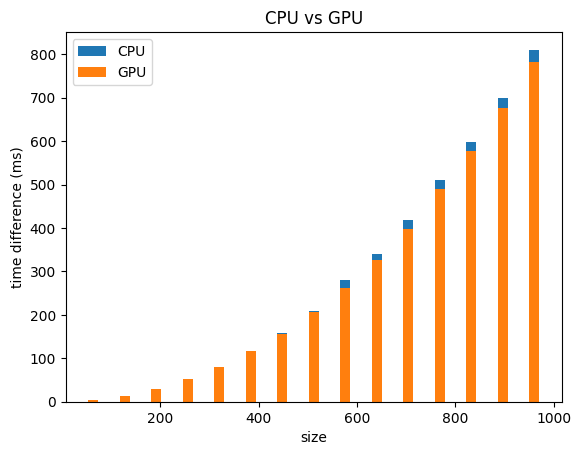

In [9]:

# 因为CPU 和 GPU 运行时间比较接近，为了体现每一组时间的差异，计算两个运行时间的差值，使用柱状图展示，柱子的宽度为20，大于零用蓝色，小于零用红色
plt.bar(sizes, cpu_times, width=20, label='CPU')
plt.bar(sizes, gpu_times, width=20, label='GPU')
plt.xlabel('size')
plt.ylabel('time difference (ms)')
plt.title('CPU vs GPU')
plt.legend()
plt.show()

# 3 Pytorch性能分析

现实工程中的代码往往耦合较多，单单打印时间不足以分析性能瓶颈，Pytorch 提供了性能分析工具，可以分析代码的瓶颈

pytorch 提供了两种性能分析工具：
1. torch.profiler
2. torch.utils.bottleneck

本节将介绍 torch.profiler。先看使用示例

In [1]:
import torch
from model.model import FGPT
from torch.profiler import profile, record_function, ProfilerActivity


# # 设置随机种子
# set_seed(42)
# if torch.cuda.is_available():
#     print("GPU is available")
# else:
#     print("GPU is not available")

d_k = 64
d_v = 64
d_model = 256
d_ff = 1024
N = 6
H = 8

batch_size = 32
sql_len = 1024
model = FGPT(d_k, d_v, d_model, H, d_ff, N).to('cuda')
x = torch.randn(batch_size, sql_len, d_model).to('cuda')
y = torch.randn(batch_size, sql_len, d_model).to('cuda')

# 定义损失函数
criterion = torch.nn.MSELoss()
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    with record_function("FGPT"):
        for i in range(10): 
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=16))
# 

STAGE:2025-03-22 22:51:37 15475:15475 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-03-22 22:51:38 15475:15475 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-03-22 22:51:38 15475:15475 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   FGPT        31.90%     779.305ms        54.34%        1.328s        1.328s             1  
                     Optimizer.zero_grad#Adam.zero_grad         0.03%     811.000us         0.03%     811.000us      81.100us            10  
                                           aten::linear         0.16%       3.824ms         5.66%     138.375ms     384.375us           360  
                                          aten::reshape         0.07%       1.781ms         1.07%      26.264ms      13.896us          1890  
      

# 4 GPU分析工具

# 5 CPU 性能分析工具